In [ ]:
# Installation of a library that allows connection to a GitHub repository
# ==============================================================================
!pip install gitpython

# https://www.kaggle.com/code/igones/eda-store-sales-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
# Data processing
# ==============================================================================
import pandas as pd
import numpy as np
from datetime import datetime
import tabulate
from scipy import stats

# Acces to GitHub
# ==============================================================================
import git
import shutil
import os
import requests
import zipfile
import io
from io import BytesIO

# Math and statistics functions
# ==============================================================================
import math

# Data preparation
# ==============================================================================
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA # Análisis de Componentes Principales

# Graphs
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px


### Functions

This part of the code will have functions created for the project.

In [ ]:
def extra_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.day
    df['day_week'] = df['date'].dt.weekday
    df['weekmonth'] = (df['day'] - 1) // 7 + 1
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['payment'] = df['date'].agg(lambda x: 1 if x.day==15 else 1 if x == x.days_in_month else 0)
    return df

# Reading the data from the repository

In this part, we will use the connection to our repository so we can access to the necesary information needed to run the notebook.

In [ ]:
#URL Repository
url_repository = "https://github.com/fdofrancoc/MonografiaEspecializacionAnaliticaYCienciaDatos/blob/main/store-sales-time-series-forecasting.zip?raw=true"

response_repository = requests.get(url_repository)

if response_repository.status_code == 200:
  zip_ref = zipfile.ZipFile(io.BytesIO(response_repository.content), 'r')

  # List all the files in the ZIP file
  file_list = zip_ref.namelist()

  holiday_events = pd.read_csv(zip_ref.open(file_list[0]))
  oil = pd.read_csv(zip_ref.open(file_list[1]))
  sample_submission = pd.read_csv(zip_ref.open(file_list[2]))
  stores = pd.read_csv(zip_ref.open(file_list[3]))
  test = pd.read_csv(zip_ref.open(file_list[4]))
  train = pd.read_csv(zip_ref.open(file_list[5]))
  transactions = pd.read_csv(zip_ref.open(file_list[6]))

else:
    print(f"Failed to download file. Status code: {response_repository.status_code}")

In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


# EDA (Exploratory Data Analysis)

For this part of the project we will use the train file and the other file to have more information.

In [ ]:
# Renombrar variables
oil.rename(columns={"dcoilwtico": "oil_price"},inplace = True)
stores.rename(columns={"city": "city_store","state":"state_store","type":"type_store","cluster":"cluster_store"},inplace = True)
holiday_events.rename(columns={"type":"type_day","locale":"type_holiday"},inplace = True)

In [ ]:
# Agrupamiento de la BD
train_merged = pd.merge(train, stores,how='left', on ='store_nbr')
train_merged = pd.merge(train_merged, holiday_events,how='left', on ='date')
train_merged = pd.merge(train_merged, oil,how='left', on ='date')
train_merged = pd.merge(train_merged, transactions,how='left', on =['date','store_nbr'])

In [ ]:
train_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city_store,state_store,type_store,cluster_store,type_day,type_holiday,locale_name,description,transferred,oil_price,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,NaN,NaN


In [ ]:
# Aplicación de la función extra_features
train_merged = extra_features(train_merged)

In [ ]:
train_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city_store,state_store,type_store,cluster_store,...,description,transferred,oil_price,transactions,day,day_week,weekmonth,month,year,payment
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,NaN,NaN,1,1,1,1,2013,0


In [ ]:
# Cantidad de valores nulos
train_merged.isnull().sum()

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city_store             0
state_store            0
type_store             0
cluster_store          0
type_day         2551824
type_holiday     2551824
locale_name      2551824
description      2551824
transferred      2551824
oil_price         955152
transactions      249117
day                    0
day_week               0
weekmonth              0
month                  0
year                   0
payment                0
dtype: int64

Realizando el merge se genera unos valores nulos en ciertas variables que son cambiados de la siguiente forma:

* Los valores nulos relacionados con días se llenan como "Normal" o "Normal day" ya que son variables relacionadas a festivos en el país y aquellos valores nulos están relacionados a días no feriados (algunos serán reemplazados por None).
* El valor asociado al precio del petróleo se reemplaza por None debido a que como son valores asociados a la bolsa, los valores nulos están relacionados a días no transaccionales dentro de la bolsa de valores

In [ ]:
# Renombra datos que aparecen como nulos
train_merged['type_day'].replace(to_replace=np.nan, value='Normal', inplace=True)
train_merged['type_holiday'].replace(to_replace=np.nan, value='None', inplace=True)
train_merged['locale_name'].replace(to_replace=np.nan, value='None', inplace=True)
train_merged['description'].replace(to_replace=np.nan, value='Normal day', inplace=True)
train_merged['transferred'].replace(to_replace=np.nan, value='None', inplace=True)

# Toma el precio del petroleo del dia anterior y se elimina los datos nulos de la columna transacciones
train_merged['oil_price'].fillna(method="ffill", inplace = True)
train_merged.dropna(inplace = True)
#train_merged = train_merged.loc[train_merged['type_holiday']!='None']

In [ ]:
train_merged.tail()

,id,date,store_nbr,family,sales,onpromotion,city_store,state_store,type_store,cluster_store,...,description,transferred,oil_price,transactions,day,day_week,weekmonth,month,year,payment
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,...,Fundacion de Riobamba,False,47.57,2155.0,15,1,3,8,2017,1
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,...,Fundacion de Riobamba,False,47.57,2155.0,15,1,3,8,2017,1
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,...,Fundacion de Riobamba,False,47.57,2155.0,15,1,3,8,2017,1
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,...,Fundacion de Riobamba,False,47.57,2155.0,15,1,3,8,2017,1
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,...,Fundacion de Riobamba,False,47.57,2155.0,15,1,3,8,2017,1


In [ ]:
# Cantidad de valores nulos
train_merged.isnull().sum()

id               0
date             0
store_nbr        0
family           0
sales            0
onpromotion      0
city_store       0
state_store      0
type_store       0
cluster_store    0
type_day         0
type_holiday     0
locale_name      0
description      0
transferred      0
oil_price        0
transactions     0
day              0
day_week         0
weekmonth        0
month            0
year             0
payment          0
dtype: int64

In [ ]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2805198 entries, 1782 to 3054347
Data columns (total 23 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             int64         
 1   date           datetime64[ns]
 2   store_nbr      int64         
 3   family         object        
 4   sales          float64       
 5   onpromotion    int64         
 6   city_store     object        
 7   state_store    object        
 8   type_store     object        
 9   cluster_store  int64         
 10  type_day       object        
 11  type_holiday   object        
 12  locale_name    object        
 13  description    object        
 14  transferred    object        
 15  oil_price      float64       
 16  transactions   float64       
 17  day            int64         
 18  day_week       int64         
 19  weekmonth      int64         
 20  month          int64         
 21  year           int64         
 22  payment        int64         
dtypes: d

### ¿Cúal es el comportamiento de las ventas?

* Anuales
* Mensuales
* Semanales

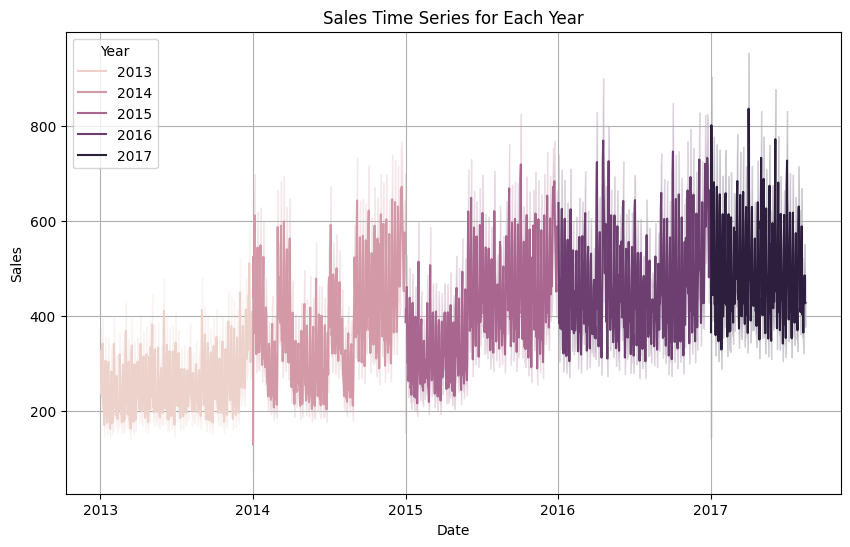

In [ ]:
# Grafica de saldos por año
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='sales', hue='year', data=train_merged)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Time Series for Each Year')
plt.grid(True)
plt.legend(title='Year', loc='upper left')
plt.show()

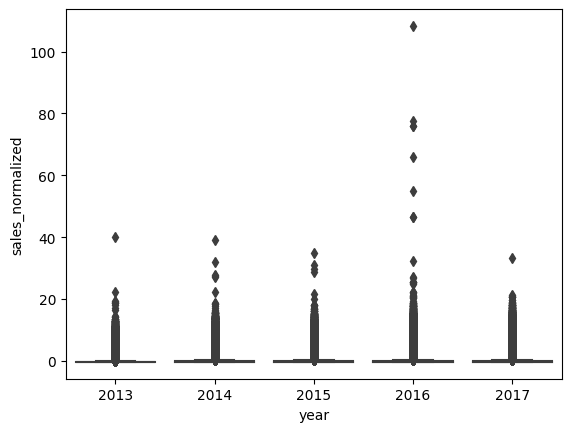

In [ ]:

train_merged['sales_normalized'] = (train_merged['sales'] - train_merged['sales'].mean()) / train_merged['sales'].std()

# Crear el boxplot normalizado
sns.boxplot(x='year', y='sales_normalized', data=train_merged)

# Mostrar el boxplot
import matplotlib.pyplot as plt
plt.show()


<Axes: xlabel='month', ylabel='sales_normalized'>

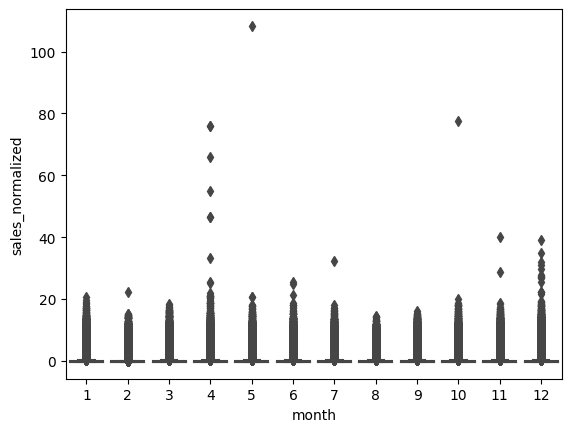

In [ ]:
sns.boxplot(x = 'month', y = 'sales_normalized', data=train_merged)

<ipython-input-19-78e48911d253>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_Series['date'] = pd.to_datetime(month_Series['date'])


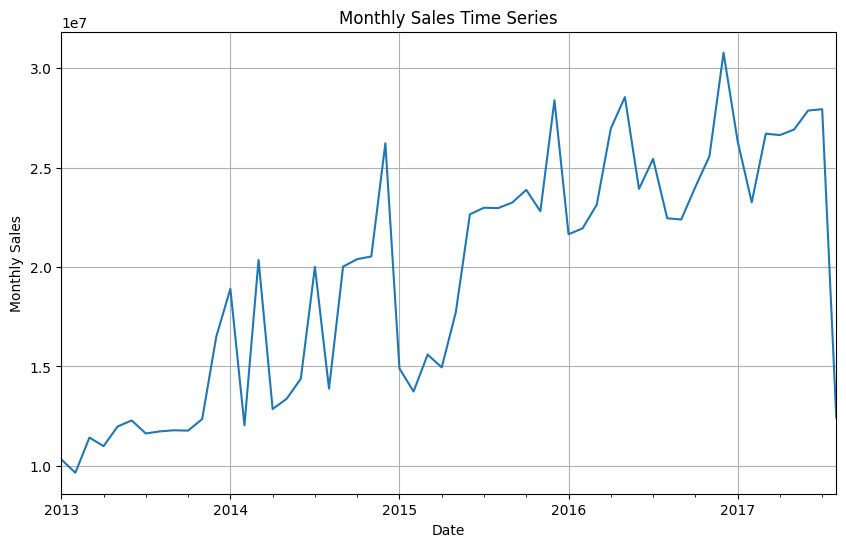

In [ ]:
month_Series = train_merged[['date','sales']]
month_Series['date'] = pd.to_datetime(month_Series['date'])
month_Series.set_index('date', inplace=True)
monthly_sales = month_Series['sales'].resample('M').sum()

# Plot the monthly sales data as a time series
plt.figure(figsize=(10, 6))
monthly_sales.plot()
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.title('Monthly Sales Time Series')
plt.grid(True)
plt.show()

### ¿Cúal es el comportamiento de las ventas por Familia?

In [ ]:
sales_family = train_merged.groupby('family').agg(family_occurancy = ('sales',lambda x: np.sum(x>0)))
sales_family.reset_index(inplace = True)

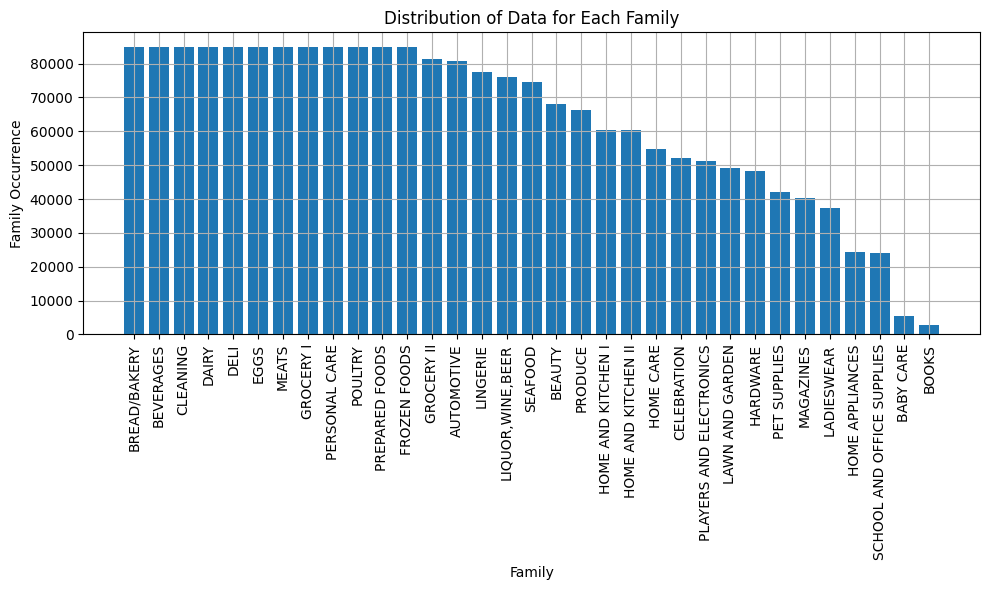

In [ ]:
# Sort the DataFrame by 'family_occurancy' in descending order
sales_family_sorted = sales_family.sort_values(by='family_occurancy', ascending=False)

# Creating plot
plt.figure(figsize=(10, 6))
plt.bar(sales_family_sorted['family'], sales_family_sorted['family_occurancy'])
plt.xlabel('Family')
plt.ylabel('Family Occurrence')
plt.title('Distribution of Data for Each Family')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

En el gráfico podemos observar que las mayores ventas están relacionadas con productos relacionados con la canasta familiar y aseo y siendo las últimas categorías de menor venta los productos de ropa femenina, electrodoméstico cuidado de bebés y libros

In [ ]:
# Group by 'family' and 'year' and calculate family_occurancy
sales_family = train_merged.groupby(['family', 'year']).agg(family_occurancy=('sales', lambda x: np.sum(x > 0)))
sales_family.reset_index(inplace=True)

# Convert numeric years to string labels
sales_family['year'] = sales_family['year'].replace([2013, 2014, 2015, 2016, 2017], ['2013', '2014', '2015', '2016', '2017'])

# Create the bar chart using plotly
fig = px.bar(
    sales_family,
    x='family',
    y='family_occurancy',
    color='year',
    barmode='group',
    title='Distribution of sales per family and year',
    height=600
)

# Customize the chart layout
fig.update_layout(
    title={'y': 0.98, 'x': 0.5},
    xaxis={'categoryorder': 'total descending'}
)

# Show the chart
fig.show()

### ¿Los días feriados tienen una influencia sobre las ventas? ¿También influye en algunos productos?

In [ ]:
aux = train_merged[train_merged['sales']>0]

aux = aux[aux['type_day'] !='Event']
aux = aux[aux['type_day'] !='Work Day']

aux1 = aux.groupby(['type_holiday','family']).agg(sales_mean = ('sales','mean'))
holiday_sales = pd.DataFrame(aux1).reset_index()

fig = px.bar(holiday_sales, x = 'family', y = 'sales_mean',title = 'Mean sales for each product family', color ='type_holiday',barmode ='group', height=800)
fig.update_layout(title={'y':0.98,'x':0.5}, xaxis={'categoryorder':'total descending'})
fig.show()

Como podemos observar en el gráfico, los días feriados relacionados a eventos nacionales y regionales traen mayores ventas que los días normales.

También podemos observar que los festivos locales y los días normales tienen ventas similiares a excepción de la familia de comidas refrigeradas que para los locales tiene una venta mayor que los otros tipos de días.

## Análisis de selección de Familia para modelo

In [ ]:
# Agrupar por año
grouped = train_merged.groupby('year')

# Calcular las métricas por separado
cumulative_sales = grouped['sales'].sum()
variation = grouped['sales'].sum().diff().shift(-1)  # Variación
volatility = grouped['sales'].std()  # Volatilidad de ventas
max_sales = grouped['sales'].max()  # Máximo
min_sales = grouped['sales'].min()  # Mínimo

# Crear un DataFrame final con las métricas
sales_metrics = pd.DataFrame({
    'Variation': variation,
    #'Variation Percentage': variation_percentage,
    'Volatility': volatility,
    'Max Sales': max_sales,
    'Min Sales': min_sales,
    'Cumulative Sales': cumulative_sales
})

In [ ]:
pd.options.display.float_format = '{:.2f}'.format  # Establece el formato a dos decimales

# Muestra el DataFrame sin notación científica
print(sales_metrics)

        Variation  Volatility  Max Sales  Min Sales  Cumulative Sales
year                                                                 
2013  70520872.47      786.91   46271.00       0.00      142472327.24
2014  30838938.16     1068.54   45361.00       0.00      212993199.71
2015  52992072.97     1134.99   40351.46       0.00      243832137.87
2016 -98755887.85     1320.44  124717.00       0.00      296824210.84
2017          NaN     1366.16   38422.62       0.00      198068322.99


In [ ]:
# Filtra las filas donde la familia sea "GROCERY I"
grocery_i_sales = train_merged[train_merged['family'] == 'GROCERY I']

# Agrupar por año
grouped = grocery_i_sales.groupby('year')

# Calcular las métricas por separado
cumulative_sales = grouped['sales'].sum()
variation = grouped['sales'].sum().diff().shift(-1)  # Variación
volatility = grouped['sales'].std()  # Volatilidad de ventas
max_sales = grouped['sales'].max()  # Máximo
min_sales = grouped['sales'].min()  # Mínimo

# Crear un DataFrame final con las métricas
sales_metrics = pd.DataFrame({
    'Variation': variation,
    'Volatility': volatility,
    'Max Sales': max_sales,
    'Min Sales': min_sales,
    'Cumulative Sales': cumulative_sales
}).reset_index()

print(sales_metrics)

   year    Variation  Volatility  Max Sales  Min Sales  Cumulative Sales
0  2013   7621430.70     2215.86   46271.00       0.00       59200265.00
1  2014  10258727.34     2522.49   45361.00     236.00       66821695.70
2  2015  11680501.90     2635.76   40351.46     597.00       77080423.04
3  2016 -30477204.00     3282.50  124717.00       0.00       88760924.94
4  2017          NaN     2994.29   38422.62     165.00       58283720.94


In [ ]:
# Agrupar por año y familia y calcular las ventas totales
sales_by_family_year = train_merged.groupby(['year', 'family'])['sales'].sum().reset_index()

# Calcular las ventas totales por año
total_sales_by_year = train_merged.groupby('year')['sales'].sum()

# Fusionar los dos DataFrames para obtener las ventas totales por año en cada fila
sales_by_family_year = sales_by_family_year.merge(total_sales_by_year, on='year', suffixes=('', '_total'))

# Calcular el porcentaje de venta que representa cada familia en cada año
sales_by_family_year['sales_percentage'] = (sales_by_family_year['sales'] / sales_by_family_year['sales_total']) * 100

# Tomar el top 5 de familias por año
top_5_by_year = sales_by_family_year.groupby('year').apply(lambda x: x.nlargest(5, 'sales_percentage'))
print(top_5_by_year)


          year        family       sales  sales_total  sales_percentage
year                                                                   
2013 12   2013     GROCERY I 59200265.00 142472327.24             41.55
     3    2013     BEVERAGES 22077089.00 142472327.24             15.50
     7    2013      CLEANING 17760118.00 142472327.24             12.47
     8    2013         DAIRY  7858863.00 142472327.24              5.52
     5    2013  BREAD/BAKERY  7087716.14 142472327.24              4.97
2014 45   2014     GROCERY I 66821695.70 212993199.71             31.37
     36   2014     BEVERAGES 41695143.00 212993199.71             19.58
     63   2014       PRODUCE 23849793.98 212993199.71             11.20
     40   2014      CLEANING 19821861.00 212993199.71              9.31
     41   2014         DAIRY 13701427.00 212993199.71              6.43
2015 78   2015     GROCERY I 77080423.04 243832137.87             31.61
     69   2015     BEVERAGES 49008269.00 243832137.87           

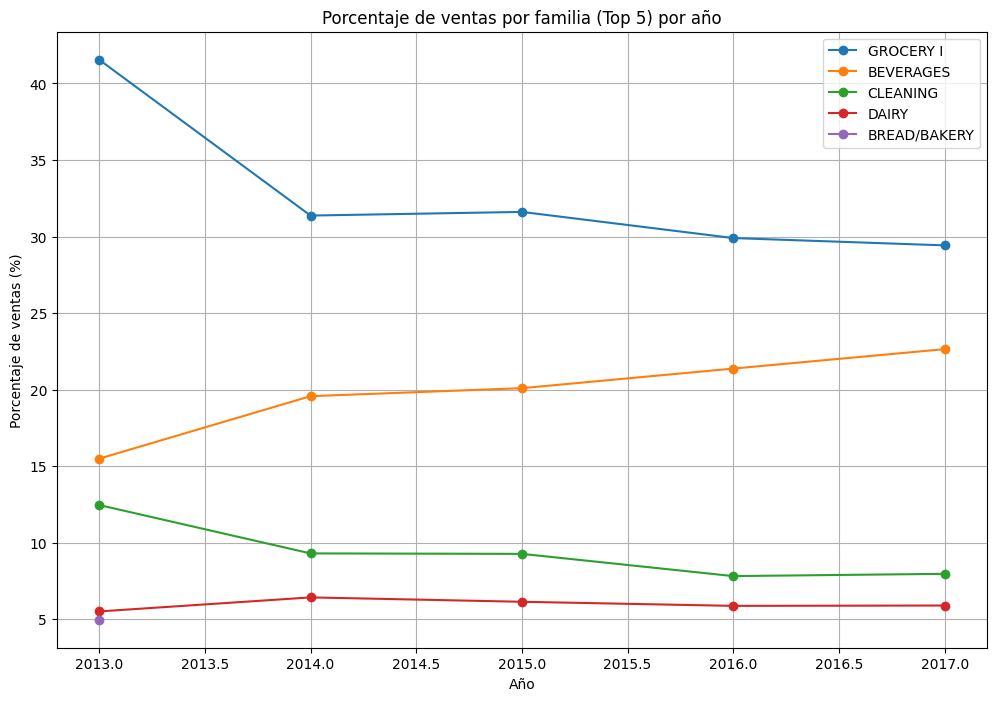

In [ ]:
# Agrupar los datos por familia y año
year_graph = pd.unique(top_5_by_year['year'])
familias = pd.unique(top_5_by_year['family'])[:-1]

plt.figure(figsize=(12, 8))

for fam in familias:
    percentages = top_5_by_year[top_5_by_year['family'] == fam]
    plt.plot(percentages['year'], percentages['sales_percentage'], label=fam, marker='o')

plt.xlabel('Año')
plt.ylabel('Porcentaje de ventas (%)')
plt.title('Porcentaje de ventas por familia (Top 5) por año')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
top_5_by_year

year        family       sales  sales_total  sales_percentage
year                                                                   
2013 12   2013     GROCERY I 59200265.00 142472327.24             41.55
     3    2013     BEVERAGES 22077089.00 142472327.24             15.50
     7    2013      CLEANING 17760118.00 142472327.24             12.47
     8    2013         DAIRY  7858863.00 142472327.24              5.52
     5    2013  BREAD/BAKERY  7087716.14 142472327.24              4.97
2014 45   2014     GROCERY I 66821695.70 212993199.71             31.37
     36   2014     BEVERAGES 41695143.00 212993199.71             19.58
     63   2014       PRODUCE 23849793.98 212993199.71             11.20
     40   2014      CLEANING 19821861.00 212993199.71              9.31
     41   2014         DAIRY 13701427.00 212993199.71              6.43
2015 78   2015     GROCERY I 77080423.04 243832137.87             31.61
     69   2015     BEVERAGES 49008269.00 243832137.87             20.10
     96   2015       PRODUCE 26031271.69 243832137.87             10.68
     73   2015      CLEANING 22618458.00 243832137.87              9.28
     74   2015         DAIRY 14988318.00 243832137.87              6.15
2016 111  2016     GROCERY I 88760924.94 296824210.84             29.90
     102  2016     BEVERAGES 63456596.00 296824210.84             21.38
     129  2016       PRODUCE 45314754.81 296824210.84             15.27
     106  2016      CLEANING 23223656.00 296824210.84              7.82
     107  2016         DAIRY 17452498.00 296824210.84              5.88
2017 144  2017     GROCERY I 58283720.94 198068322.99             29.43
     135  2017     BEVERAGES 44858817.00 198068322.99             22.65
     162  2017       PRODUCE 29816255.58 198068322.99             15.05
     139  2017      CLEANING 15791284.00 198068322.99              7.97
     140  2017         DAIRY 11692401.00 198068322.99              5.90

In [ ]:
Grocery = train_merged[train_merged['family']=="GROCERY I"]

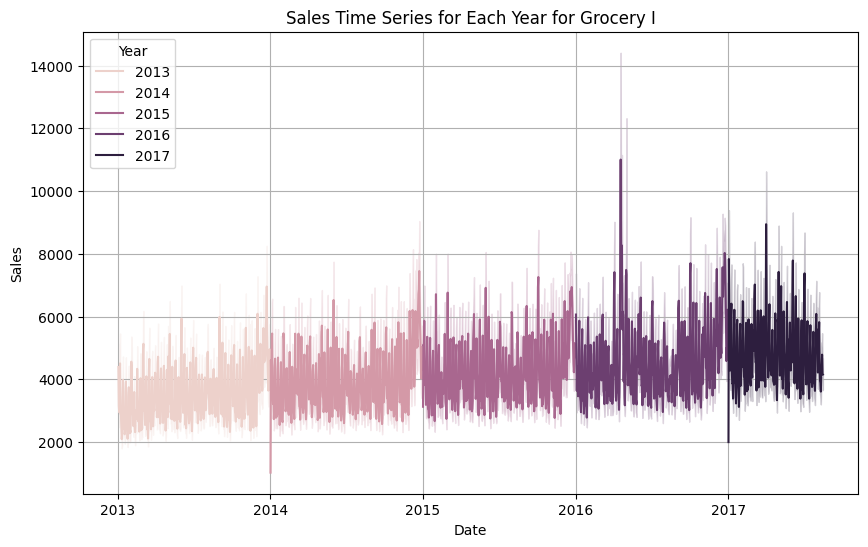

In [ ]:
# Grafica de saldos por año
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='sales', hue='year', data=Grocery)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Time Series for Each Year for Grocery I')
plt.grid(True)
plt.legend(title='Year', loc='upper left')
plt.show()

<ipython-input-44-73c122686f71>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



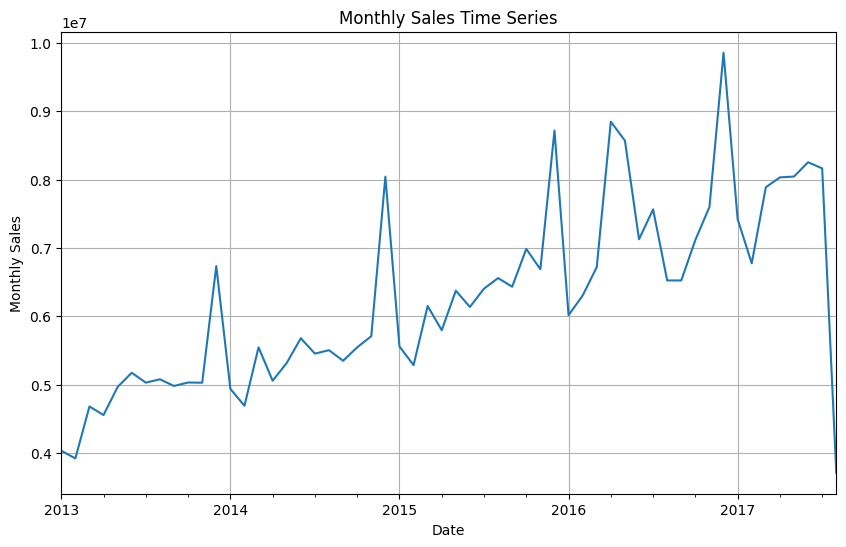

In [ ]:
month_Series_grocery = Grocery[['date','sales']]
month_Series_grocery['date'] = pd.to_datetime(month_Series_grocery['date'])
month_Series_grocery.set_index('date', inplace=True)
monthly_sales_grocery = month_Series_grocery['sales'].resample('M').sum()

# Plot the monthly sales data as a time series
plt.figure(figsize=(10, 6))
monthly_sales_grocery.plot()
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.title('Monthly Sales Time Series')
plt.grid(True)
plt.show()